# Week 7

Logistic regression with PyTorch

In [25]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
from torchvision import datasets
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt


'''
Step 1: Prepare dataset
'''
# Use data with only 4 and 9 as labels: which is hardest to classify
label_1, label_2 = 4, 9
# will see softmax later on

# MNIST training data 70,000
# train_set has size 60,000
train_set = datasets.MNIST(root='./mnist_data/',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

# MNIST testing data
test_set = datasets.MNIST(root='./mnist_data/',
                          train=False,
                          transform=transforms.ToTensor())

In [26]:
torch.set_printoptions(linewidth=150)
print(train_set.data.shape)
print(train_set.data[0])
print(train_set.targets[0]) # label

torch.Size([60000, 28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170

In [27]:
# Use data with two labels
idx = (train_set.targets == label_1) + (train_set.targets == label_2)
print(idx)

tensor([False, False,  True,  ..., False, False, False])


In [28]:
train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]
train_set.targets[train_set.targets==label_1] = -1
train_set.targets[train_set.targets==label_2] = 1
print(train_set.targets)
print(train_set.data.shape)

tensor([-1,  1, -1,  ..., -1,  1,  1])
torch.Size([11791, 28, 28])


In [29]:
# Use data with two labels
idx = (test_set.targets == label_1) + (test_set.targets == label_2)
test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]
test_set.targets[test_set.targets == label_1] = -1
test_set.targets[test_set.targets == label_2] = 1

In [30]:
'''
Step 2: Define the neural network class
'''
class LogisticRegression(nn.Module):
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # MNIST data is 28x28 images
    def __init__(self):
        super().__init__()
        input_dim = 28*28
        self.linear = nn.Linear(input_dim, 1, bias=True)  # input dimension = 28 * 28// output dimension =1 //takes x as an input, returns a^Tx + b

    ''' forward given input x '''
    def forward(self, x) :
        x = self.linear(x.float().view(-1, 28*28)) # x <- a^T x + b , # view technique => reshaping tensor
        # initially x is (28, 28) -> (1, 784)
        return x  # a^Tx + b

In [32]:
'''
Step 3: Create the model, specify loss function and optimizer.
'''
model = LogisticRegression()                                   # Define a Neural Network Model
# model(x) = m(x) = a^Tx + b  

def logistic_loss(output, target):  # l_{log}(x, y) = log(1+exp(-y*x)) 
    return -torch.nn.functional.logsigmoid(target*output)

loss_function = logistic_loss                                                   # Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)   # specify SGD with learning rate = alpha
# model.parameters() -> a, b (it is at parant class)

In [33]:
'''
Step 4: Train model with SGD
'''
for _ in range(1000) :
    # Sample a random data for training
    ind = np.random.randint(0, len(train_set.data)-1)
    image, label = train_set.data[ind], train_set.targets[ind]

    # Clear previously computed gradient
    optimizer.zero_grad()

    # then compute gradient with forward and backward passes
    train_loss = loss_function(model(image), label.float())
    train_loss.backward()

    #(This syntax will make more sense once we learn about minibatches)

    # perform SGD step (parameter update)
    optimizer.step()  # x^{(k+1)} = x^{(k)} - alpha * grad(f)

In [34]:
'''
Step 5: Test model (Evaluate the accuracy)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

# Evaluate accuracy using test data
for ind in range(len(test_set.data)) :

    image, label = test_set.data[ind], test_set.targets[ind]

    # evaluate model
    output = model(image)  # y = m(x)

    # Calculate cumulative loss  # l_log(m(x), y)
    test_loss += loss_function(output, label.float()).item()

    # Make a prediction
    if output.item() * label.item() >= 0:  # y * (a^Tx+b) > 0
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_set.data), correct, len(test_set.data),
        100. * correct / len(test_set.data)))

[Test set] Average loss: 7.2876, Accuracy: 1878/1991 (94.32%)



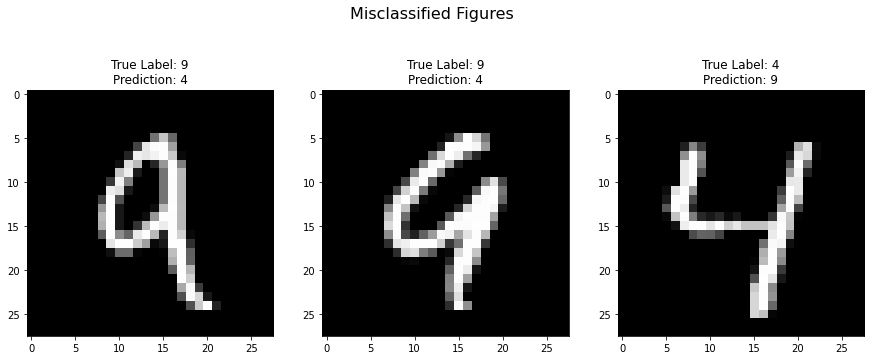

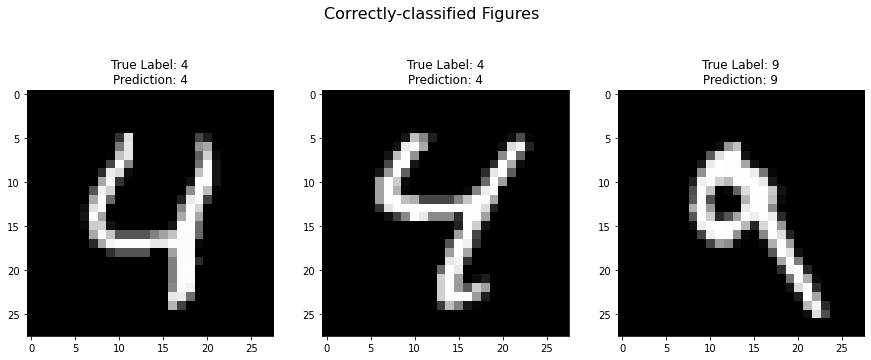

In [35]:
'''
Step 6: Show some incorrectly classified images and some correctly classified ones
''' 
# Misclassified images
fig = plt.figure(1, figsize=(15, 6))
fig.suptitle('Misclassified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[misclassified_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[misclassified_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_2))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_1))
    plt.imshow(image, cmap='gray')
plt.show()

# Correctly classified images
fig = plt.figure(2, figsize=(15, 6))
fig.suptitle('Correctly-classified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[correct_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[correct_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_1))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_2))
    plt.imshow(image, cmap='gray')
plt.show()

### More on torch.nn Module

In [36]:
# model parameters visible as an iterator (a generator is an iterator)
print(model.parameters())

<generator object Module.parameters at 0x000001C8630529C8>


In [39]:
for parameter in model.parameters():
    print(parameter.shape)
print(' ')    
for name, param in model.named_parameters():
    print(name)
    print(param.shape)

torch.Size([1, 784])
torch.Size([1])
 
linear.weight
torch.Size([1, 784])
linear.bias
torch.Size([1])


In [44]:
# model parameter directly obtainable from layer
print(model.linear)
print(model.linear.weight.shape)
#print(model.linear.bias)  #available if bias=True

Linear(in_features=784, out_features=1, bias=True)
torch.Size([1, 784])


In [46]:
# # evaluate the model several equivalent ways
# model(image)
print(model.linear.bias)  #available if bias=True
print(torch.sum(model.linear.weight*test_set.data[0].reshape(28*28))+model.linear.bias)

Parameter containing:
tensor([-0.0024], requires_grad=True)
tensor([-343.1318], grad_fn=<AddBackward0>)


In [47]:
print(torch.sum(model.linear.weight.detach()*test_set.data[0].reshape(28*28))+model.linear.bias.detach())

tensor([-343.1318])


In [58]:
# print(model.linear(test_set.data[0].float().view(-1, 28*28)))
# print(model.linear(test_set.data[0].float().view(-1, 28*28)).detach())
print(model(test_set.data[0]))
# a^Tx + b <0 -> we are going to say the data of label -1
# a^Tx + b > 0 -> we are going to say the data of label 1
print(test_set.targets[0])

tensor([[-343.1318]], grad_fn=<AddmmBackward>)
tensor(-1)


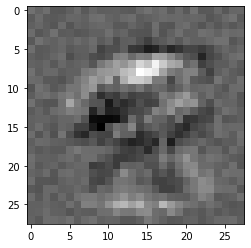

In [59]:
# view the weight trained through logistic regression
weight = model.linear.weight.detach().reshape(28,28).numpy()  # a^Tx = a_1x_1 + a_2x_2 + ... a_784x_784
weight = weight - np.min(weight)
weight = weight/np.max(weight)
plt.imshow(weight, cmap='gray')
plt.show()

# in order to say the image is 4 -> a^Tx+b < 0

## Dataloader

[Test set] Average loss: 0.1560, Accuracy: 1884/1991 (94.63%)



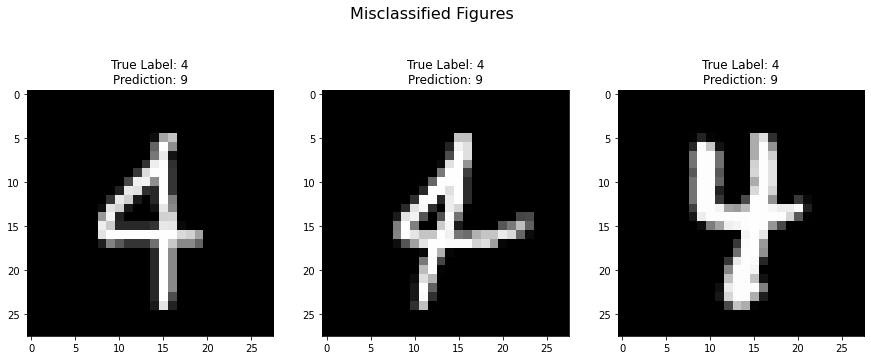

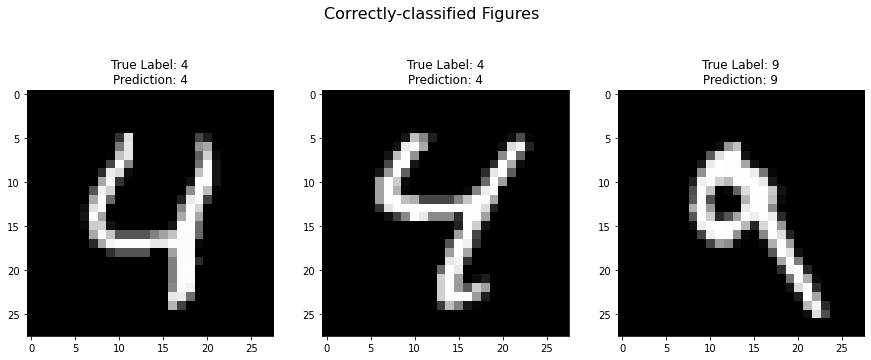

In [67]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms


'''
Step 1: (same step)
'''
# Use data with only 4 and 9 as labels: which is hardest to classify
label_1, label_2 = 4, 9

# MNIST training data
train_set = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

# Use data with two labels
idx = (train_set.targets == label_1) + (train_set.targets == label_2)
train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]
train_set.targets[train_set.targets == label_1] = -1
train_set.targets[train_set.targets == label_2] = 1

# MNIST testing data
test_set = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor())

# Use data with two labels
idx = (test_set.targets == label_1) + (test_set.targets == label_2)
test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]
test_set.targets[test_set.targets == label_1] = -1
test_set.targets[test_set.targets == label_2] = 1
    

'''
Step 2: (same step)
'''
class LR(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # MNIST data is 28x28 images
    def __init__(self, input_dim=28*28) :
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)

    ''' forward given input x '''
    def forward(self, x) :
        return self.linear(x.float().view(-1, 28*28))

'''
Step 3: (LOOK HERE)
'''
model = LR()                                   

def logistic_loss(output, target):
    return -torch.nn.functional.logsigmoid(target*output)

loss_function = logistic_loss
optimizer = torch.optim.SGD(model.parameters(), lr=255*1e-4)   # LR scaled up by 255

    
'''
Step 4: Train model with SGD (LOOK HERE)
'''
# Use DataLoader class (Press Ctrl+/ to comment in/out)

# 1. SGD
# from torch.utils.data import RandomSampler
# train_loader = DataLoader(dataset=train_set, batch_size=1, sampler=RandomSampler(train_set, replacement=True))

# 2. cyclic SGD
# train_loader = DataLoader(dataset=train_set, batch_size=1)

# 3. random reshuffled SGD
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
# N : size of dataset, M : sample size(batch_size)

# Train the model
iter_count = 0
for image, label in train_loader:
    iter_count += 1
    if iter_count > 1000:
        break

    # Clear previously computed gradient
    optimizer.zero_grad()

    # then compute gradient with forward and backward passes
    train_loss = loss_function(model(image), label.float())
    train_loss.backward()

    # perform SGD step (parameter update)
    optimizer.step()


'''
Step 5: Test model (LOOK HERE)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

# Test data
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)
# no need to shuffle test data

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)

    # Calculate cumulative loss
    test_loss += loss_function(output, label.float()).item()

    # Make a prediction
    if output.item() * label.item() >= 0 : 
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))

'''
Step 6: (same step)
''' 
# Misclassified images
fig = plt.figure(1, figsize=(15, 6))
fig.suptitle('Misclassified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[misclassified_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[misclassified_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_2))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_1))
    plt.imshow(image, cmap='gray')
plt.show()

# Correctly classified images
fig = plt.figure(2, figsize=(15, 6))
fig.suptitle('Correctly-classified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[correct_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[correct_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_1))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_2))
    plt.imshow(image, cmap='gray')
plt.show()

### Dataloader scales data

In [28]:
from torch.utils.data import RandomSampler
train_set = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
#print(train_set.data[0])
train_loader = DataLoader(dataset=train_set, batch_size=1, sampler=RandomSampler(tr ain_set, replacement=True))
print(next(iter(train_loader)))

[tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [

## Epochs

Time ellapsed in training is: 7.181997060775757
[Test set] Average loss: 0.0932, Accuracy: 1930/1991 (96.94%)



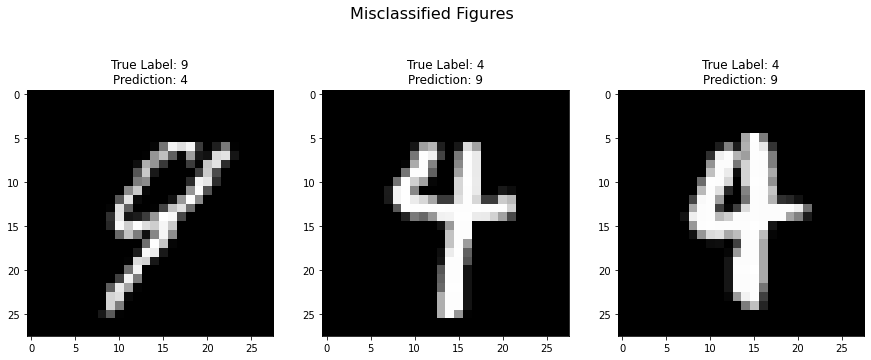

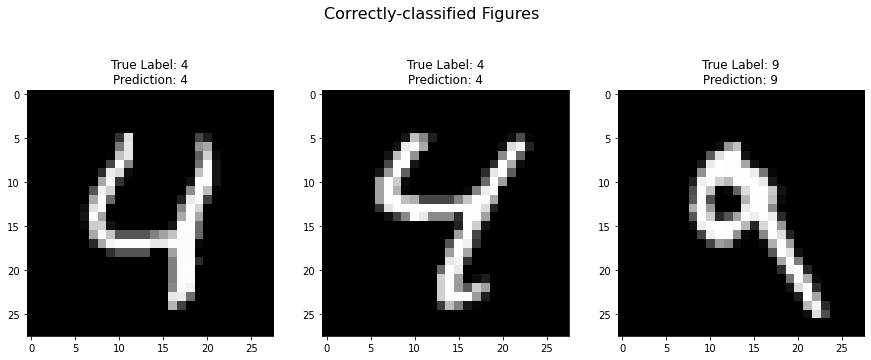

In [29]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

'''
Step 1: (same step)
'''
# Use data with only 4 and 9 as labels: which is hardest to classify
label_1, label_2 = 4, 9

# MNIST training data
train_set = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

# Use data with two labels
idx = (train_set.targets == label_1) + (train_set.targets == label_2)
train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]
train_set.targets[train_set.targets == label_1] = -1
train_set.targets[train_set.targets == label_2] = 1

# MNIST testing data
test_set = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor())

# Use data with two labels
idx = (test_set.targets == label_1) + (test_set.targets == label_2)
test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]
test_set.targets[test_set.targets == label_1] = -1
test_set.targets[test_set.targets == label_2] = 1
    

'''
Step 2: (same step)
'''
class LR(nn.Module) :
    '''
    Initialize model
        input_dim : dimension of given input data
    '''
    # MNIST data is 28x28 images
    def __init__(self, input_dim=28*28) :
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)

    ''' forward given input x '''
    def forward(self, x) :
        return self.linear(x.float().view(-1, 28*28))

'''
Step 3: (same step)
'''
model = LR()                                   # Define a Neural Network Model

def logistic_loss(output, target):
    return -torch.nn.functional.logsigmoid(target*output)

loss_function = logistic_loss                                                   # Specify loss function
optimizer = torch.optim.SGD(model.parameters(), lr=255*1e-4)   # specify SGD with learning rate



'''
Step 4: Train model with SGD (LOOK HERE)
'''
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)

import time
start = time.time()
# Train the model for 3 epochs
for epoch in range(3) :
    for image, label in train_loader :
        # Clear previously computed gradient
        optimizer.zero_grad()

        # then compute gradient with forward and backward passes
        train_loss = loss_function(model(image), label.float())
        train_loss.backward()

        # perform SGD step (parameter update)
        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))

'''
Step 5: (same step)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

# Test data
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)
# no need to shuffle test data

# Evaluate accuracy using test data
for ind, (image, label) in enumerate(test_loader) :

    # Forward pass
    output = model(image)

    # Calculate cumulative loss
    test_loss += loss_function(output, label.float()).item()

    # Make a prediction
    if output.item() * label.item() >= 0 : 
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

# Print out the results
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /len(test_loader), correct, len(test_loader),
        100. * correct / len(test_loader)))

'''
Step 6: (same step)
''' 
# Misclassified images
fig = plt.figure(1, figsize=(15, 6))
fig.suptitle('Misclassified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[misclassified_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[misclassified_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_2))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_1))
    plt.imshow(image, cmap='gray')
plt.show()

# Correctly classified images
fig = plt.figure(2, figsize=(15, 6))
fig.suptitle('Correctly-classified Figures', fontsize=16)

for k in range(3) :
    image = test_set.data[correct_ind[k]].cpu().numpy().astype('uint8')
    ax = fig.add_subplot(1, 3, k+1)
    true_label = test_set.targets[correct_ind[k]]

    if true_label == -1 :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_1, label_1))
    else :
        ax.set_title('True Label: {}\nPrediction: {}'.format(label_2, label_2))
    plt.imshow(image, cmap='gray')
plt.show()
